In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely
import numpy as np
import pandas as pd
import mapclassify as mc

# Vías

## Densidad de vías para área del proyecto

A continuación se desarrolla un script para saber cuál es la densidad de vías, definida en m2 sobre km2, dentro del área del proyecto establecida, en este caso el Resguardo Indígena Alto Unuma.

C:\Users\Andres Wilches\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Andres Wilches\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Límites de los Natural Breaks: [  0.          76.55056354 133.38024989 211.43951752 326.45028819]


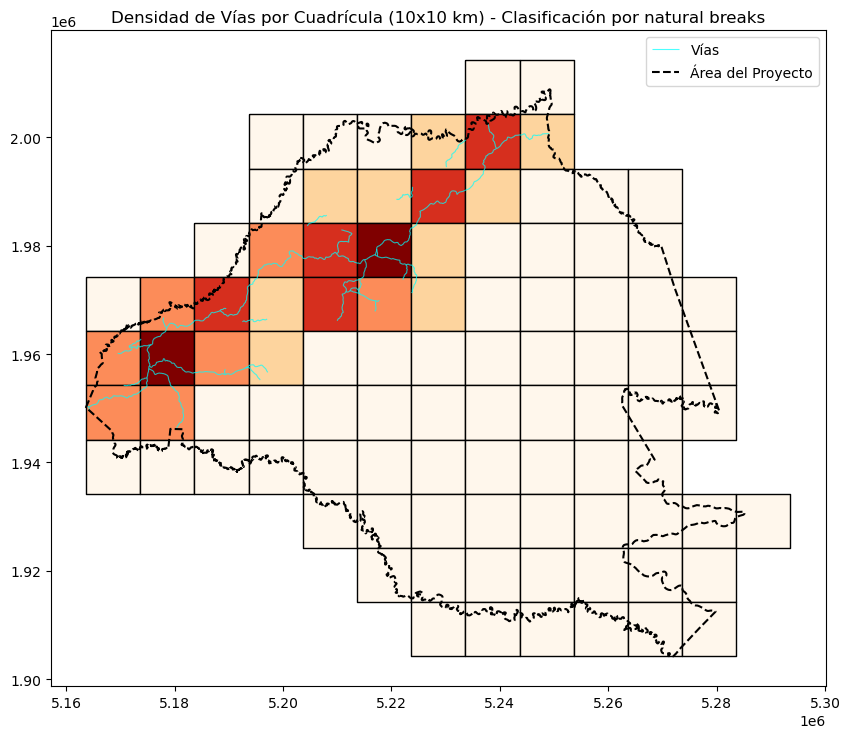

In [18]:
# Cargar datos
# Se cargan los archivos de shapefile que contienen el área del proyecto y las vías
project_area = gpd.read_file("Data\\RI_UNUMA_Project.shp")
vias = gpd.read_file("Data\\Vias_project_area.shp")

# ---- Definir límites del área del proyecto ----
# Se extraen los límites de la extensión del área del proyecto y el sistema de referencia (CRS)
bounds = project_area.total_bounds
crs = project_area.crs  # Sistema de referencia

# ---- Creación de la cuadrícula ----
# Se define la resolución de la cuadrícula en 10 km (10,000 metros)
res = 10000
xmin, ymin, xmax, ymax = bounds

# Se generan las coordenadas de las columnas y filas de la cuadrícula
cols = np.arange(np.floor(xmin), np.ceil(xmax + res), res)
rows = np.arange(np.floor(ymin), np.ceil(ymax + res), res)[::-1]  # Invertir filas para orden cartesiano

# Se crean polígonos cuadrados para cada celda de la cuadrícula
polygons = [
    shapely.Polygon([(x, y), (x + res, y), (x + res, y - res), (x, y - res)])
    for x in cols for y in rows
]

# Se genera un GeoDataFrame con la cuadrícula creada
grid = gpd.GeoDataFrame({'geometry': polygons}, crs=crs)

# ---- Filtrado de la cuadrícula ----
# Se filtran las celdas que intersectan con el área del proyecto
grid = grid[grid.intersects(project_area.union_all())]
grid['id'] = grid.index  # Se asigna un ID único a cada celda

# ---- Recorte de las vías dentro de cada celda ----
# Se intersectan las vías con la cuadrícula para obtener solo las que están dentro de cada celda
vias_clip = gpd.overlay(vias, grid, how='intersection')

# ---- Cálculo de la longitud de vías por celda ----
# Se calcula la longitud de las vías en metros dentro de cada celda
vias_clip["longitud_via_m"] = vias_clip.geometry.length

# Se agrupa la información sumando la longitud total de vías por celda
vias_grid = vias_clip.groupby("id")["longitud_via_m"].sum().reset_index()

# Se unen los datos de longitud de vías a la cuadrícula original
grid = grid.merge(vias_grid, on="id", how="left").fillna(0)

# ---- Cálculo de la densidad de vías ----
# Se calcula el área de cada celda en km² (10x10 km = 100 km² por celda)
grid["area_km2"] = (res / 1000) ** 2  # Convertir metros cuadrados a kilómetros cuadrados

# Se calcula la densidad de vías en cada celda (longitud de vías en metros por km²)
grid["densidad_vias"] = grid["longitud_via_m"] / grid["area_km2"]

# ---- Clasificación mediante Natural Breaks ----
# Se aplican los Natural Breaks para segmentar los valores de densidad en 5 categorías
nb = mc.NaturalBreaks(grid["densidad_vias"], k=5)
print("Límites de los Natural Breaks:", nb.bins)

# ---- Visualización de los resultados ----
fig, ax = plt.subplots(figsize=(10, 10))

# Se plotea la cuadrícula con la clasificación por densidad de vías
grid.plot(column="densidad_vias", cmap="OrRd", edgecolor="black",
          scheme="NaturalBreaks", k=5, legend=True, ax=ax,
          legend_kwds={'fmt': "{:.2f}"})

# Se plotean las vías y el área del proyecto
vias.plot(ax=ax, color="cyan", linewidth=0.8, alpha=0.7, label="Vías")
project_area.boundary.plot(ax=ax, color="black", linewidth=1.5, linestyle="dashed", label="Área del Proyecto")

# Ajustes finales del gráfico
ax.set_title("Densidad de Vías por Cuadrícula (10x10 km) - Clasificación por natural breaks")
ax.legend()
plt.show()

Este script calcula la media y la desviación estándar de la densidad de vías dentro de la cuadrícula y utiliza estos valores para definir límites de clasificación personalizados. Estos límites permiten una segmentación basada en la distribución estadística de los datos. La media representa el valor promedio de densidad de vías en las celdas, mientras que la desviación estándar indica la dispersión de los valores en relación con la media. Este método es útil para clasificar los datos en rangos que reflejan la variabilidad real de la distribución.

Media de densidad de vías: 29.668134470649555
Desviación estándar de densidad de vías: 64.71975518280034
Límites Basados en Media y Desviación Estándar: [0, 29.668134470649555, 94.38788965344989, 159.10764483625024, 326.45028819115976]


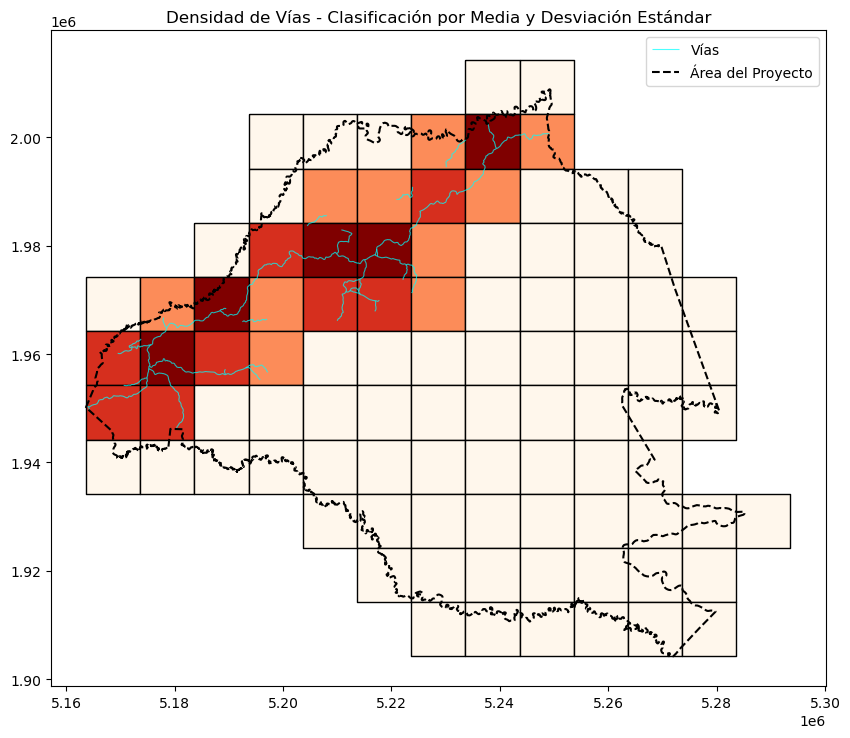

In [32]:
# ---- Cálculo de Media y Desviación Estándar ----
# Se calcula la media (promedio) de la densidad de vías y su desviación estándar.
mean_density = grid["densidad_vias"].mean()
std_density = grid["densidad_vias"].std()

# Se imprimen los valores calculados
print("Media de densidad de vías:", mean_density)
print("Desviación estándar de densidad de vías:", std_density)

# ---- Definición de límites ----
# Se definen los límites basados en la media y la desviación estándar:
# - Media - 1σ: un valor por debajo del promedio
# - Media: punto central de la distribución
# - Media + 1σ, +2σ, +3σ: valores crecientes que representan desviaciones mayores
bins = [0, mean_density - std_density, mean_density, mean_density + std_density, mean_density + 2 * std_density, grid["densidad_vias"].max()]

# Se eliminan valores negativos para evitar clasificaciones incorrectas
bins = [b for b in bins if b >= 0]

print("Límites Basados en Media y Desviación Estándar:", bins)

# ---- Visualización de Resultados ----
# Se genera un gráfico que muestra la densidad de vías usando la clasificación definida por los límites
fig, ax = plt.subplots(figsize=(10, 10))

grid.plot(column="densidad_vias", cmap="OrRd", edgecolor="black",
          scheme="UserDefined", classification_kwds={"bins": bins},
          legend=True, ax=ax, legend_kwds={'fmt': "{:.2f}"})

# Se plotean las vías y el área del proyecto
vias.plot(ax=ax, color="cyan", linewidth=0.8, alpha=0.7, label="Vías")
project_area.boundary.plot(ax=ax, color="black", linewidth=1.5, linestyle="dashed", label="Área del Proyecto")

# Configuración final del gráfico
ax.set_title("Densidad de Vías - Clasificación por Media y Desviación Estándar")
ax.legend()
plt.show()

## Densidad de vías para el ROI

Dado que el objetivo del proyecto, es encontrar una zona similar al área de estudio, para establecer una línea base de un proyecto de carbono, se delimita un ROI (Region Of Interest) sobre el cual, se realiza el mismo procedimiento anteriormente descrito, pero esta vez se tiene en cuenta en la visualización los límites definidos por medio de la media y la desviación estándar, para encontrar efectivamente las zonas espaciales que tengan mayor similitud a la situación en el área del proyecto.

📌 Valor máximo de densidad de vías: 1875.92 metros/km²


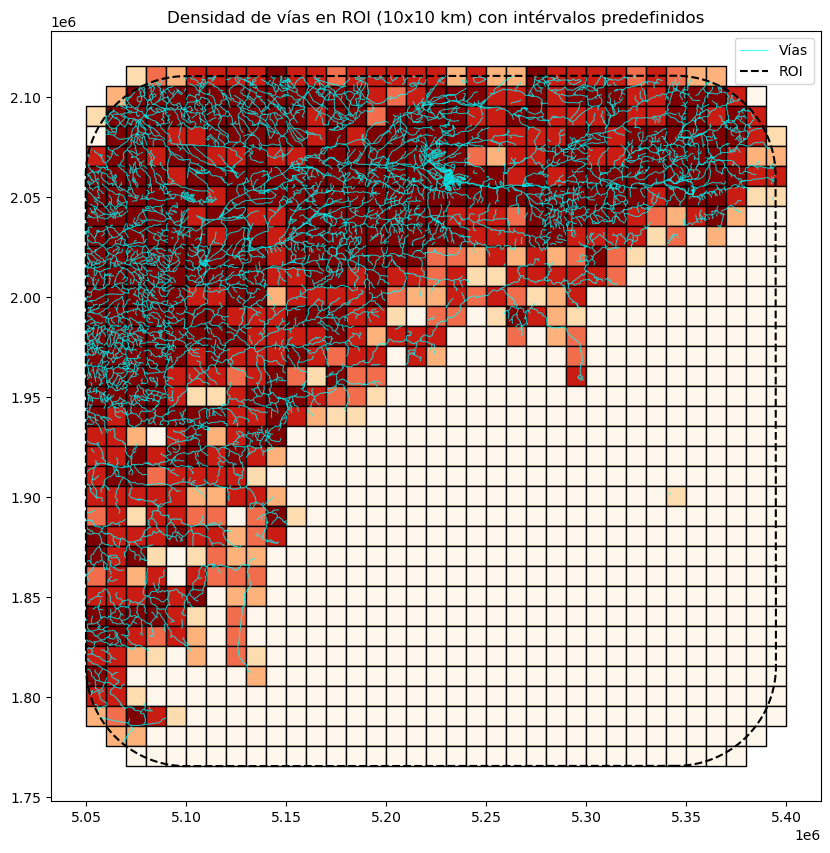

In [30]:
# ---- Carga de Datos ----
# Se cargan los archivos shapefile que contienen la región de interés (ROI) y las vías en la zona
ROI = gpd.read_file("Data\\ROI_2.shp")
vias_roi = gpd.read_file("Data\\Vias_roi.shp")

# ---- Definir Límites del Área de Interés ----
# Se extraen los límites espaciales y el sistema de referencia (CRS)
bounds_roi = ROI.total_bounds
crs = ROI.crs  # Sistema de referencia

# ---- Creación de la Cuadrícula ----
# Se define la resolución de la cuadrícula en 10 km (10,000 metros)
res = 10000
xmin, ymin, xmax, ymax = bounds_roi

# Se generan las coordenadas de columnas y filas para la cuadrícula
cols = np.arange(np.floor(xmin), np.ceil(xmax + res), res)
rows = np.arange(np.floor(ymin), np.ceil(ymax + res), res)[::-1]  # Invertir filas para orden cartesiano

# Se crean polígonos cuadrados para cada celda de la cuadrícula
polygons = [
    shapely.Polygon([(x, y), (x + res, y), (x + res, y - res), (x, y - res)])
    for x in cols for y in rows
]

# Se genera un GeoDataFrame con la cuadrícula creada
grid_roi = gpd.GeoDataFrame({'geometry': polygons}, crs=crs)

# ---- Filtrado de la cuadrícula ----
# Se filtran las celdas que intersectan con el área de interés
grid_roi = grid_roi[grid_roi.intersects(ROI.union_all())]
grid_roi['id'] = grid_roi.index # Se asigna un ID único a cada celda

# ---- Recorte de vías dentro de cada celda ----
# Se intersectan las vías con la cuadrícula para obtener solo las que están dentro de cada celda
vias_clip_roi = gpd.overlay(vias_roi, grid_roi, how='intersection')

# ---- Cálculo de la longitud de vías por celda ----
# Se calcula la longitud total de vías dentro de cada celda
vias_clip_roi["longitud_via_m"] = vias_clip_roi.geometry.length
vias_grid_roi = vias_clip_roi.groupby("id")["longitud_via_m"].sum().reset_index()

# Se unen los datos de longitud de vías a la cuadrícula original
grid_roi = grid_roi.merge(vias_grid_roi, on="id", how="left").fillna(0)

# ---- Cálculo de la densidad de vías ----
# Se calcula el área de cada celda en km² (10x10 km = 100 km² por celda)
grid_roi["area_km2"] = (res / 1000) ** 2  # Convertir metros cuadrados a kilómetros cuadrados

# Calcular la densidad de vías (longitud de vías en metros por km²)
grid_roi["densidad_vias"] = grid_roi["longitud_via_m"] / grid_roi["area_km2"]

# ---- Obtener y mostrar el máximo valor de densidad de vías ----
max_density = grid_roi["densidad_vias"].max()
print(f"📌 Valor máximo de densidad de vías: {max_density:.2f} metros/km²")

# ---- Definición de límites de clasificación ----
# Se establecen los límites de clasificación utilizando intervalos definidos previamente
natural_breaks_bins = [0, 29.668134470649555, 94.38788965344989, 159.10764483625024, 326.45028819115976, 1876]

# ---- Visualización de Resultados ----
fig, ax = plt.subplots(figsize=(10, 10))

# Se plotea la cuadrícula con la clasificación definida
grid_roi.plot(column="densidad_vias", cmap="OrRd", edgecolor="black",
              legend=True, ax=ax, 
              scheme="UserDefined", classification_kwds={"bins": natural_breaks_bins},
              legend_kwds={'fmt': "{:.2f}"})

# Se plotean las vías y el área del proyecto
vias_roi.plot(ax=ax, color="cyan", linewidth=0.8, alpha=0.7, label="Vías")
ROI.boundary.plot(ax=ax, color="black", linewidth=1.5, linestyle="dashed", label="ROI")

# Configuración final del gráfico
ax.set_title("Densidad de vías en ROI (10x10 km) con intérvalos predefinidos")
ax.legend()
plt.show()

## Clasificación

Una vez se han definido los intervalos, se clasifica la densidad de vías del ROI según los límites definidos para el área del proyecto. Se asigna una clase a cada celda en función de la densidad de vías, con valores del 0 al 4.

In [36]:
# ---- Copia del GeoDataFrame ----
# Se crea una copia del GeoDataFrame de la cuadrícula para trabajar con la clasificación
grid_class = grid_roi.copy()

# ---- Definición de límites y clases ----
# Se establecen los límites de densidad de vías y sus respectivas categorías (de 0 a 4)
bins = [0, 29.668134470649555, 94.38788965344989, 159.10764483625024, 326.45028819115976, 1876]
values = [4, 3, 2, 1, 0]

# ---- Asignación de clases ----
# Se clasifica la densidad de vías en la cuadrícula utilizando los límites definidos
grid_class["clase_densidad"] = pd.cut(grid_class["densidad_vias"], bins=bins, labels=values, include_lowest=True)

# Se convierte la columna de clasificación a enteros
grid_class["clase_densidad"] = grid_class["clase_densidad"].astype(int)

# Verificar los valores generados
print("📌 Distribución de la clasificación:")
print(grid_class["clase_densidad"].value_counts().sort_index())

📌 Distribución de la clasificación:
clase_densidad
0    297
1    185
2     47
3     44
4    638
Name: count, dtype: int64


Una vez se ha definido la clase de densidad, se visualizan los resultados de la densidad de vías por cuadrícula.

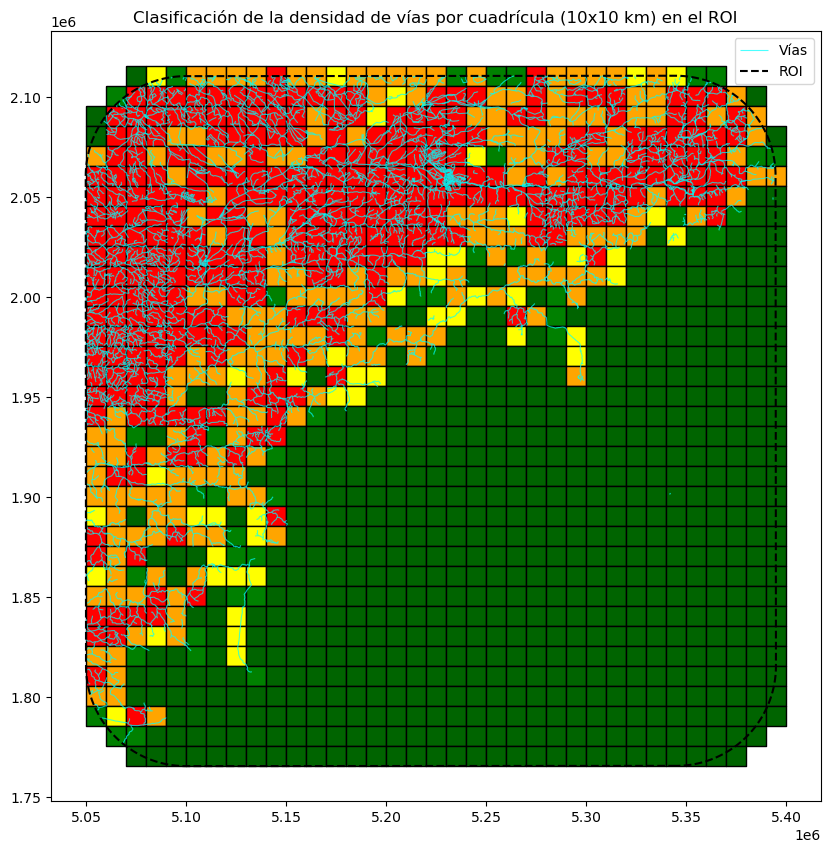

In [39]:
# ---- Definición de la paleta de colores ----
# Se asocia cada clase de densidad con un color específico para facilitar la interpretación visual
color_map = {
    4: "darkgreen",  # Menor densidad
    3: "green",
    2: "yellow",
    1: "orange",
    0: "red"  # Mayor densidad
}

# Crear la visualización
fig, ax = plt.subplots(figsize=(10, 10))

# Se aplica la paleta de colores definida a la cuadrícula
grid_class.plot(color=grid_class["clase_densidad"].map(color_map), edgecolor="black", ax=ax)

# Se plotean las vías y el ROI
vias_roi.plot(ax=ax, color="cyan", linewidth=0.8, alpha=0.7, label="Vías")
ROI.boundary.plot(ax=ax, color="black", linewidth=1.5, linestyle="dashed", label="ROI")

# Configuración del gráfico
ax.set_title("Clasificación de la densidad de vías por cuadrícula (10x10 km) en el ROI")
ax.legend()
plt.show()

# Drenajes dobles

## Densidad de drenajes dobles para área del proyecto

C:\Users\Andres Wilches\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Andres Wilches\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Límites de los Natural Breaks: [ 463.70016315 1386.81251071 2460.24280788 5382.219526   7328.89618087]


C:\Users\Andres Wilches\AppData\Local\Temp\ipykernel_17128\2236353956.py:74: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


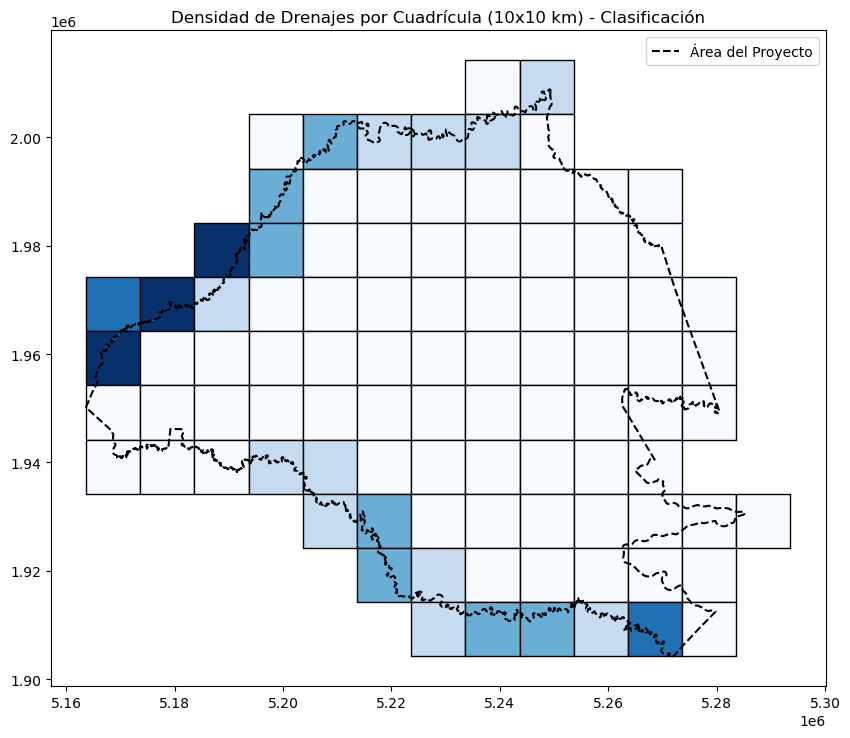

In [15]:
import geopandas as gpd
import numpy as np
import shapely
import pandas as pd
import matplotlib.pyplot as plt
import mapclassify as mc
import matplotlib.patches as mpatches

# Cargar datos
project_area = gpd.read_file("Data/RI_UNUMA_Project.shp")
drenajes = gpd.read_file("Data/Drenaje_Doble_project_area.shp")

# Obtener límites del área del proyecto
bounds = project_area.total_bounds
crs = project_area.crs  # Sistema de referencia

# Definir resolución de la cuadrícula (10 km = 10,000 m)
res = 10000
xmin, ymin, xmax, ymax = bounds

# Crear columnas y filas para la cuadrícula
cols = np.arange(np.floor(xmin), np.ceil(xmax + res), res)
rows = np.arange(np.floor(ymin), np.ceil(ymax + res), res)[::-1]  # Invertir filas para orden cartesiano

# Crear la cuadrícula
polygons = [
    shapely.Polygon([(x, y), (x + res, y), (x + res, y - res), (x, y - res)])
    for x in cols for y in rows
]
grid = gpd.GeoDataFrame({'geometry': polygons}, crs=crs)

# Filtrar celdas de la cuadrícula que intersectan con el área del proyecto
grid = grid[grid.intersects(project_area.union_all())]
grid['id'] = grid.index  # Agregar ID a cada celda

# Recortar los polígonos de drenaje dentro de cada celda de la cuadrícula
drenajes_clip = gpd.overlay(drenajes, grid, how='intersection')

# Calcular el área de drenaje en cada celda
drenajes_clip["area_drenaje_m2"] = drenajes_clip.geometry.area  # Área en m²

# Sumar la superficie total de drenajes por celda
drenajes_grid = drenajes_clip.groupby("id")["area_drenaje_m2"].sum().reset_index()

# Unir los resultados con la cuadrícula
grid = grid.merge(drenajes_grid, on="id", how="left").fillna(0)

# Calcular el área de cada celda en km²
grid["area_km2"] = (res / 1000) ** 2  # Convertir m² a km²

# Calcular la densidad de drenajes (área drenaje en m² por km² de celda)
grid["densidad_drenajes"] = grid["area_drenaje_m2"] / grid["area_km2"]

# Calcular los límites de Natural Breaks
nb = mc.NaturalBreaks(grid["densidad_drenajes"], k=5)
print("Límites de los Natural Breaks:", nb.bins)

# ---- PLOTEO DE RESULTADOS ----
fig, ax = plt.subplots(figsize=(10, 10))

# Plot de la densidad de drenajes con los límites predefinidos
grid.plot(column="densidad_drenajes", cmap="Blues", edgecolor="black",
          scheme="NaturalBreaks", k=5, legend=True, ax=ax,
          legend_kwds={'fmt': "{:.2f}"})

# Dibujar los drenajes en color cian para diferenciarlos
drenajes.plot(ax=ax, color="cyan", alpha=0.7, label="Drenajes")

# Dibujar el área del proyecto
project_area.boundary.plot(ax=ax, color="black", linewidth=1.5, linestyle="dashed", label="Área del Proyecto")

# Ajustes finales del gráfico
ax.set_title("Densidad de Drenajes por Cuadrícula (10x10 km) - Clasificación")
ax.legend()
plt.show()

590.2527587718203
1457.1998016640575
Límites Basados en Media y Desviación Estándar: [0, 590.2527587718203, 2047.4525604358778, 3504.652362099935, 7328.896180867518]


C:\Users\Andres Wilches\AppData\Local\Temp\ipykernel_17128\2577269968.py:24: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


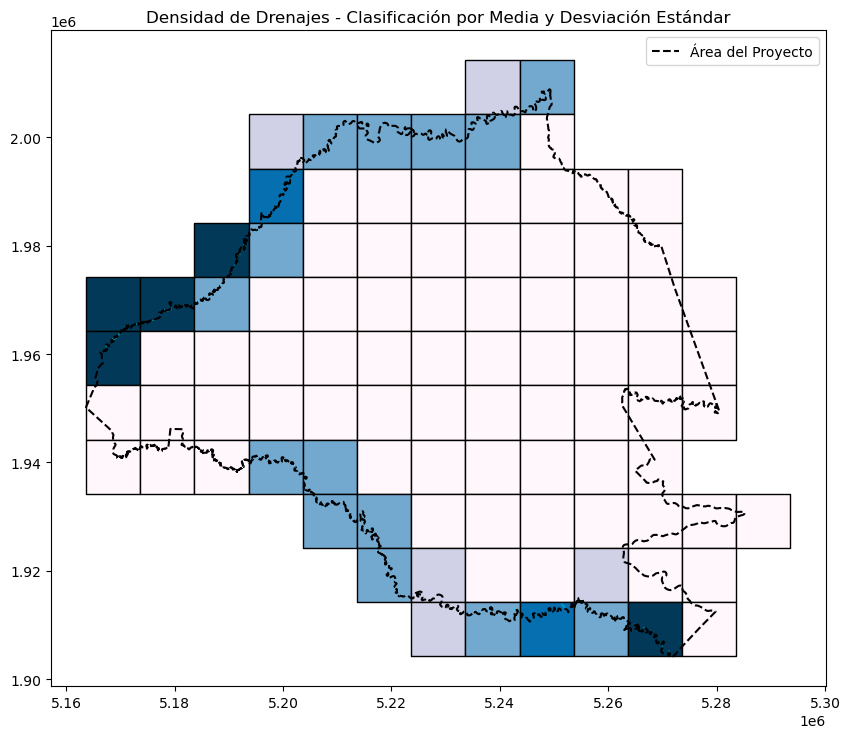

In [19]:
# Calcular media y desviación estándar
mean_density = grid["densidad_drenajes"].mean()
std_density = grid["densidad_drenajes"].std()

print(mean_density)
print(std_density)

# Definir límites manualmente: media ± 1σ, ±2σ, ±3σ
bins = [0, mean_density - std_density, mean_density, mean_density + std_density, mean_density + 2 * std_density, grid["densidad_drenajes"].max()]
bins = [b for b in bins if b >= 0]  # Asegurar valores positivos

print("Límites Basados en Media y Desviación Estándar:", bins)

# Plot usando clasificación definida
fig, ax = plt.subplots(figsize=(10, 10))
grid.plot(column="densidad_drenajes", cmap="PuBu", edgecolor="black",
          scheme="UserDefined", classification_kwds={"bins": bins},
          legend=True, ax=ax, legend_kwds={'fmt': "{:.2f}"})

drenajes.plot(ax=ax, color="cyan", linewidth=0.8, alpha=0.7, label="Drenajes")
project_area.boundary.plot(ax=ax, color="black", linewidth=1.5, linestyle="dashed", label="Área del Proyecto")

ax.set_title("Densidad de Drenajes - Clasificación por Media y Desviación Estándar")
ax.legend()
plt.show()

## Densidad de drenajes dobles para ROI

📌 Valor máximo de densidad de drenajes: 127544.60 m²/km²


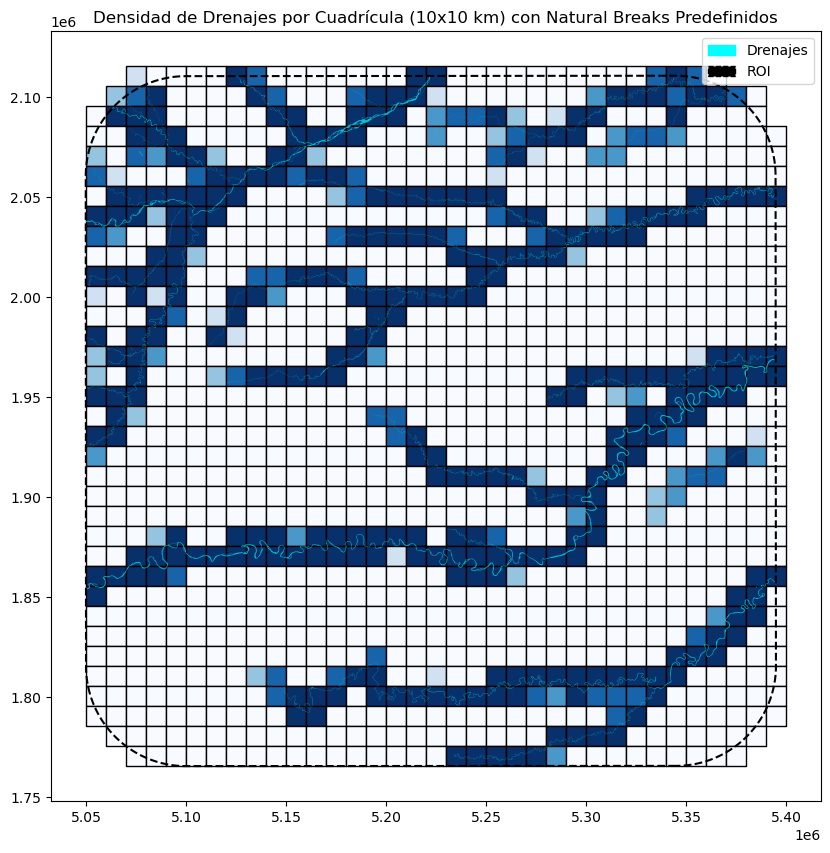

In [576]:
# Cargar datos
ROI = gpd.read_file("Data/ROI_2.shp")
drenajes_roi = gpd.read_file("Data/Drenaje_Doble_ROI.shp")  # Reemplazo de vías por drenajes

# Obtener límites del área del proyecto
bounds_roi = ROI.total_bounds
crs = ROI.crs  # Sistema de referencia

# Definir resolución de la cuadrícula (10 km = 10,000 m)
res = 10000
xmin, ymin, xmax, ymax = bounds_roi

# Crear columnas y filas para la cuadrícula
cols = np.arange(np.floor(xmin), np.ceil(xmax + res), res)
rows = np.arange(np.floor(ymin), np.ceil(ymax + res), res)[::-1]  # Invertir filas para orden cartesiano

# Crear la cuadrícula con celdas de 10x10 km
polygons = [
    shapely.Polygon([(x, y), (x + res, y), (x + res, y - res), (x, y - res)])
    for x in cols for y in rows
]
grid_roi = gpd.GeoDataFrame({'geometry': polygons}, crs=crs)

# Filtrar celdas de la cuadrícula que intersectan con el área del proyecto
grid_roi = grid_roi[grid_roi.intersects(ROI.union_all())]
grid_roi['id'] = grid_roi.index  # Agregar ID a cada celda

# Recortar los drenajes dentro de cada celda de la cuadrícula
drenajes_clip_roi = gpd.overlay(drenajes_roi, grid_roi, how='intersection')

# Calcular el área de drenaje en cada celda
drenajes_clip_roi["area_drenaje_m2"] = drenajes_clip_roi.geometry.area  # Área en m²

# Sumar la superficie total de drenajes por celda
drenajes_grid_roi = drenajes_clip_roi.groupby("id")["area_drenaje_m2"].sum().reset_index()

# Unir los resultados con la cuadrícula
grid_roi = grid_roi.merge(drenajes_grid_roi, on="id", how="left").fillna(0)

# Calcular área de cada celda en km²
grid_roi["area_km2"] = (res / 1000) ** 2  # Convertir m² a km²

# Calcular la densidad de drenajes (área drenada en m² por km² de celda)
grid_roi["densidad_drenajes"] = grid_roi["area_drenaje_m2"] / grid_roi["area_km2"]

max_density = grid_roi["densidad_drenajes"].max()
print(f"📌 Valor máximo de densidad de drenajes: {max_density:.2f} m²/km²")

# Definir los límites de clasificación basados en Natural Breaks
natural_breaks_bins = [0, 590.2527587718203, 2047.4525604358778, 3504.652362099935, 7328.896180867518, max_density]  # Ajusta estos valores según los datos

# ---- PLOTEO DE RESULTADOS ----
fig, ax = plt.subplots(figsize=(10, 10))

# Plot de la densidad de drenajes con los límites predefinidos
grid_roi.plot(column="densidad_drenajes", cmap="Blues", edgecolor="black",
              legend=True, ax=ax, 
              scheme="UserDefined", classification_kwds={"bins": natural_breaks_bins},
              legend_kwds={'fmt': "{:.2f}"})

# Dibujar los drenajes en cian
drenajes_roi.plot(ax=ax, color="cyan", alpha=0.7)

# Dibujar el área del proyecto
ROI.boundary.plot(ax=ax, color="black", linewidth=1.5, linestyle="dashed")

# 🔹 Crear la leyenda manualmente para evitar errores con PatchCollection
legend_patches = [
    mpatches.Patch(color="cyan", label="Drenajes"),
    mpatches.Patch(color="black", label="ROI", linestyle="dashed")
]

# Agregar la leyenda corregida
ax.legend(handles=legend_patches, loc="upper right")

# Ajustes finales del gráfico
ax.set_title("Densidad de Drenajes por Cuadrícula (10x10 km) con Natural Breaks Predefinidos")
plt.show()

## Clasificación

In [580]:
grid_class = grid_roi.copy()

# Definir los límites y las clases correspondientes
bins = [0, 590.2527587718203, 2047.4525604358778, 3504.652362099935, 7328.896180867518, 127545]
values = [4, 3, 2, 1, 0]

# Crear la nueva columna de clasificación
grid_class["clase_densidad"] = pd.cut(grid_class["densidad_drenajes"], bins=bins, labels=values, include_lowest=True)

# Convertir la clasificación a enteros
grid_class["clase_densidad"] = grid_class["clase_densidad"].astype(int)

# Verificar los valores generados
print("📌 Distribución de la clasificación:")
print(grid_class["clase_densidad"].value_counts().sort_index())

📌 Distribución de la clasificación:
clase_densidad
0    283
1     49
2     23
3     22
4    834
Name: count, dtype: int64


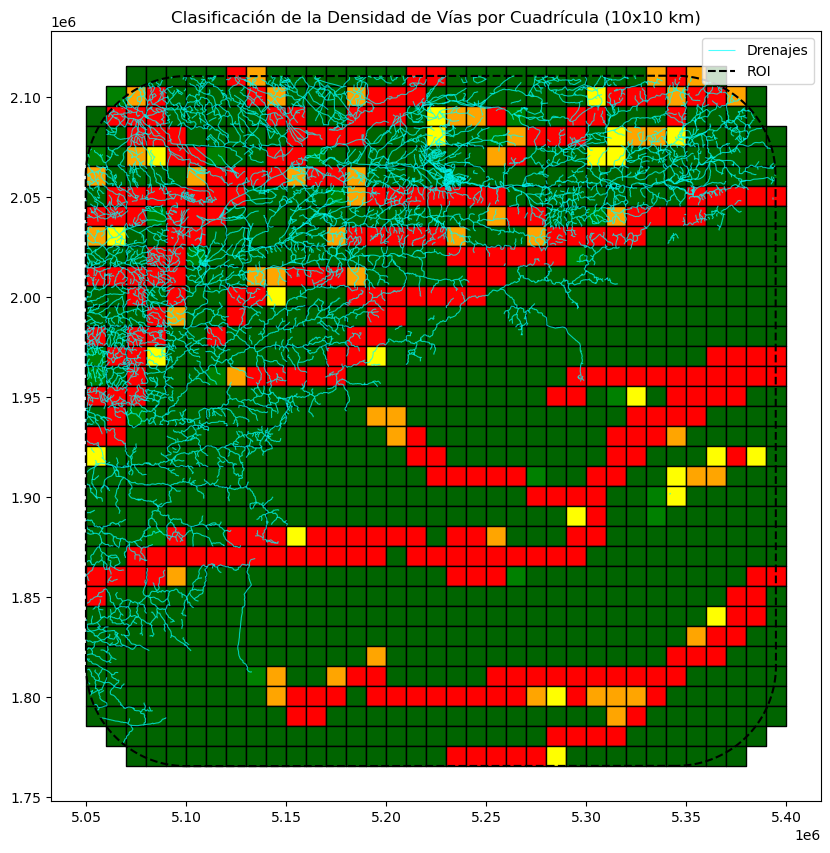

In [582]:
# Definir una paleta de colores manualmente
color_map = {
    4: "darkgreen",  # Menor densidad
    3: "green",
    2: "yellow",
    1: "orange",
    0: "red"  # Mayor densidad
}

# Crear la visualización
fig, ax = plt.subplots(figsize=(10, 10))

# Aplicar los colores manualmente
grid_class.plot(color=grid_class["clase_densidad"].map(color_map), edgecolor="black", ax=ax)

# Dibujar las vías en azul
vias_roi.plot(ax=ax, color="cyan", linewidth=0.8, alpha=0.7, label="Drenajes")

# Dibujar el área del proyecto
ROI.boundary.plot(ax=ax, color="black", linewidth=1.5, linestyle="dashed", label="ROI")

# Configuración del gráfico
ax.set_title("Clasificación de la Densidad de Vías por Cuadrícula (10x10 km)")
ax.legend()
plt.show()

# Asentamientos humanos

## Asentamientos humanos en el área del proyecto

In [593]:
# 🔹 Cargar datos (Ajusta la ruta de los archivos si es necesario)
asentamientos = gpd.read_file("Data/Rangos_CC_Project_area.shp")  # Capa de asentamientos humanos

# 🔹 Asegurar que ambas capas tengan el mismo CRS
asentamientos = asentamientos.to_crs(project_area.crs)

# 🔹 Calcular el área de cada categoría dentro del área del proyecto
asentamientos["area_m2"] = asentamientos.geometry.area  # Área en m²

# 🔹 Sumar el área total por categoría y ordenarlas de mayor a menor
area_por_categoria = asentamientos.groupby("gridcode")["area_m2"].sum().reset_index()
area_por_categoria["area_ha"] = area_por_categoria["area_m2"] / 1e4  # Convertir a ha
area_por_categoria = area_por_categoria.sort_values(by="area_ha", ascending=False)  # Ordenar de mayor a menor

# 🔹 Guardar los resultados en un archivo CSV
output_file = "area_por_categoria_asentamientos.csv"
area_por_categoria.to_csv(output_file, index=False)
print(f"📌 Resultados guardados en: {output_file}")

# 🔹 Mostrar la tabla ordenada
print("\n📌 Áreas de las categorías de asentamientos humanos dentro del área del proyecto:")
print(area_por_categoria)

📌 Resultados guardados en: area_por_categoria_asentamientos.csv

📌 Áreas de las categorías de asentamientos humanos dentro del área del proyecto:
   gridcode       area_m2        area_ha
3         4  3.202241e+09  320224.068809
2         3  1.383697e+09  138369.691941
4         5  1.009590e+09  100958.993174
1         2  6.994646e+08   69946.456392
0         1  4.380723e+08   43807.226629


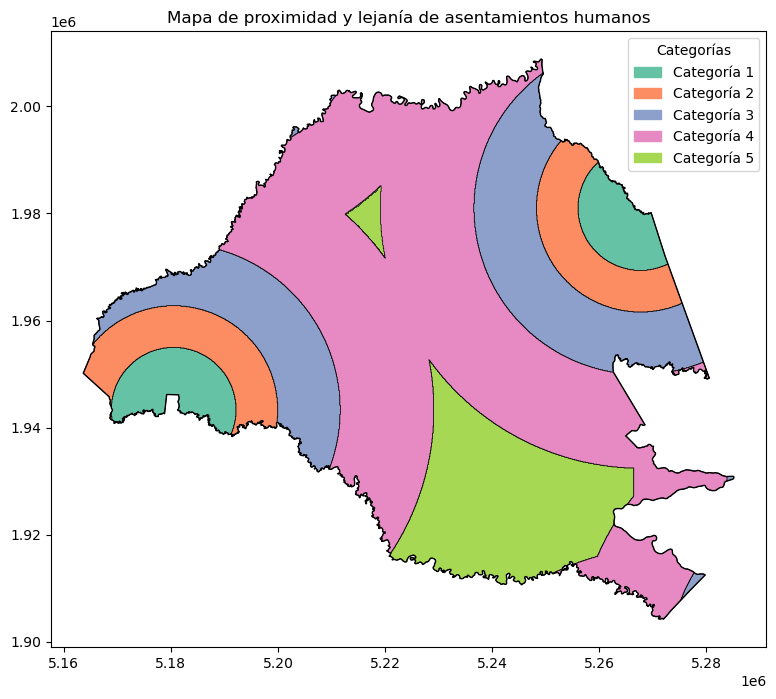

In [611]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# 🔹 Asegurar que ambas capas tengan el mismo CRS
asentamientos = asentamientos.to_crs(project_area.crs)

# 🔹 Definir una paleta de colores categórica
unique_categories = sorted(asentamientos["gridcode"].unique())  # Asegurar orden estable
colors = plt.cm.Set2(range(len(unique_categories)))  # Colores diferentes por categoría
cmap = mcolors.ListedColormap(colors)  # Usar solo estos colores
norm = mcolors.BoundaryNorm(unique_categories + [max(unique_categories) + 1], cmap.N)

# 🔹 Crear el mapa
fig, ax = plt.subplots(figsize=(10, 8))

# 🔹 Dibujar el área del proyecto en contorno negro
project_area.boundary.plot(ax=ax, color="black", linewidth=1, label="Área del Proyecto")

# 🔹 Graficar los asentamientos con colores categóricos
asentamientos.plot(column="gridcode", cmap=cmap, norm=norm, ax=ax, edgecolor="black", linewidth=0.5)

# 🔹 Crear una leyenda personalizada
handles = [mpatches.Patch(color=cmap(norm(cat)), label=f"Categoría {cat}") for cat in unique_categories]
ax.legend(handles=handles, title="Categorías", loc="upper right")

# 🔹 Ajustar el gráfico
ax.set_title("Mapa de proximidad y lejanía de asentamientos humanos")
plt.show()

## Asentamientos humanos en el ROI

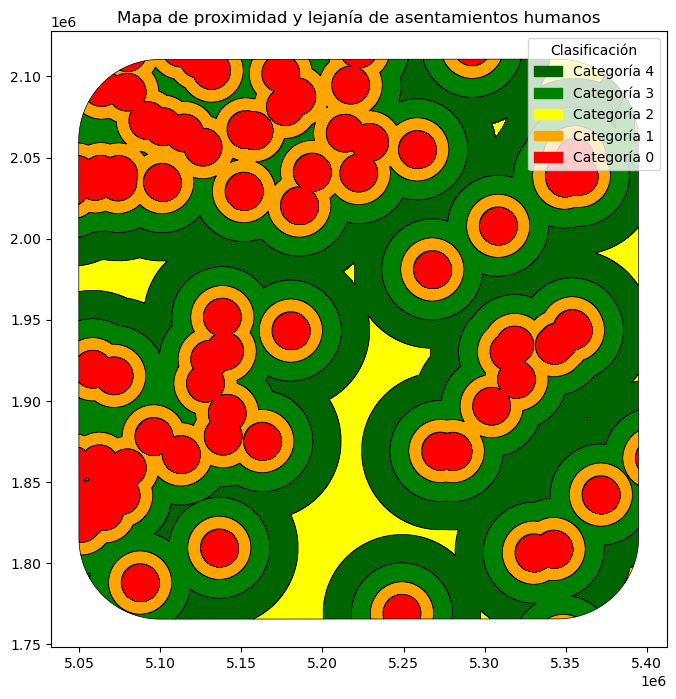

In [27]:
asentamientos_roi = gpd.read_file("Data/Rangos_CC_ROI.shp")  # Capa de asentamientos humanos

# 🔹 Crear una nueva columna con los valores ajustados
asentamientos_roi["nueva_clasificacion"] = asentamientos_roi["gridcode"].map({
    4: 4,
    3: 3,
    5: 2,
    2: 1,
    1: 0
})

# 🔹 Definir el mapa de colores para la nueva clasificación
color_map = {
    4: "darkgreen",  # Menor densidad
    3: "green",
    2: "yellow",
    1: "orange",
    0: "red"  # Mayor densidad
}

# 🔹 Crear la figura
fig, ax = plt.subplots(figsize=(10, 8))

# 🔹 Graficar cada categoría con su color correspondiente
for value, color in color_map.items():
    asentamientos_roi[asentamientos_roi["nueva_clasificacion"] == value].plot(
        ax=ax, color=color, edgecolor="black", linewidth=0.5, label=f"Categoría {value}"
    )

# 🔹 Crear una leyenda personalizada
handles = [mpatches.Patch(color=color, label=f"Categoría {value}") for value, color in color_map.items()]
ax.legend(handles=handles, title="Clasificación", loc="upper right")

# 🔹 Ajustar el gráfico
ax.set_title("Mapa de proximidad y lejanía de asentamientos humanos")

# 🔹 Mostrar el mapa
plt.show()

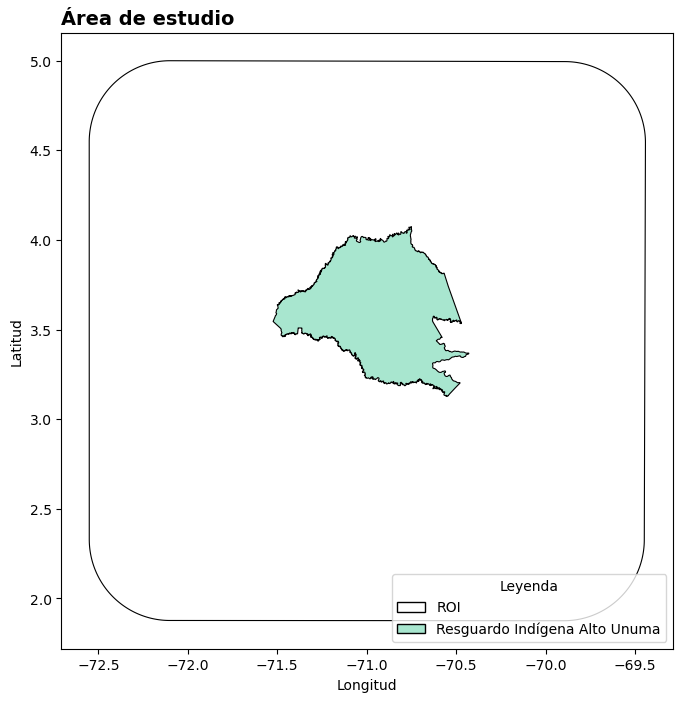

In [69]:
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as ctx  # Para agregar basemaps

# 🔹 Cargar las capas de datos
municipios = gpd.read_file("Data/Division_politico_administrativa.shp")  # Capa de la región Amazonía
ROI = gpd.read_file("Data\\ROI_2.shp")

# 🔹 Convertir a coordenadas geográficas (Lat/Lon - EPSG:4326)
ROI2 = ROI.to_crs(epsg=4326)
project_area2 = project_area.to_crs(epsg=4326)

# 🔹 Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10, 8))

# 🔹 Graficar la división político-administrativa
ROI2.plot(ax=ax, edgecolor="black", facecolor="none", linewidth=0.8, label="División político-administrativa")

# 🔹 Graficar los resguardos indígenas
project_area2.plot(ax=ax, color="#a8e6cf", edgecolor="black", linewidth=0.8, label="Resguardo Alto Unuma")

# 🔹 Crear una leyenda manual con patches
legend_patches = [
    mpatches.Patch(facecolor="none", edgecolor="black", label="ROI"),
    mpatches.Patch(facecolor="#a8e6cf", edgecolor="black", label="Resguardo Indígena Alto Unuma")
]

ax.legend(handles=legend_patches, loc="lower right", fontsize=10, title="Leyenda")

# 🔹 Agregar título
plt.title("Área de estudio", fontsize=14, fontweight="bold", loc="left")

# 🔹 Agregar coordenadas en los ejes
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")

# 🔹 Mostrar el mapa
plt.show()